In [12]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score as sk_silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

In [4]:
SCRIPT_DIR = os.getcwd()
DOCS_DIR = os.path.join(SCRIPT_DIR, "docs")
TFIDF_PKL_PATH = os.path.join(SCRIPT_DIR, "tfidf_data.pkl")


In [5]:
topwords = {
    "a", "an", "the", "this", "that", "these", "those", "such",
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves",
    "you", "your", "yours", "yourself", "yourselves",
    "he", "him", "his", "himself",
    "she", "her", "hers", "herself",
    "it", "its", "itself",
    "they", "them", "their", "theirs", "themselves",
    "am", "is", "are", "was", "were", "be", "been", "being",
    "do", "does", "did", "doing", "have", "has", "had", "having",
    "can", "could", "may", "might", "shall", "should", "will", "would", "must", "ought",
    "not", "no", "nor", "neither", "none", "never", "without",
    "and", "or", "but", "if", "while", "although", "though", "because", "since", "so", "than",
    "as", "at", "by", "for", "from", "in", "into", "of", "off", "on", "out", "over", "through", "to", "toward",
    "under", "until", "up", "upon", "with", "within", "between", "before", "after", "during", "about", "around",
}

In [6]:
def preprocess(token: str):
    t = re.sub(r"[^a-z]", "", token.lower())
    if len(t) > 1 and t not in stopwords:
        return t
    return None

In [7]:
def load_texts(max_docs=1239):
    doc_ids, texts = [], []

    for doc_id in range(1, max_docs + 1):
        path = os.path.join(DOCS_DIR, f"{doc_id:05d}")
        if not os.path.exists(path):
            continue

        with open(path, "r", encoding="utf-8") as f:
            raw = [line.strip() for line in f if line.strip()]

        tokens = []
        for w in raw:
            p = preprocess(w)
            if p:
                tokens.append(p)

        doc_ids.append(doc_id)
        texts.append(" ".join(tokens))

    print(f"Loaded {len(doc_ids)} documents from: {DOCS_DIR}")
    return doc_ids, texts



def build_or_load_tfidf(force_rebuild=False):
    if (not force_rebuild) and os.path.exists(TFIDF_PKL_PATH):
        with open(TFIDF_PKL_PATH, "rb") as f:
            data = pickle.load(f)
        vectorizer = data["vectorizer"]
        X = data["X"]
        doc_ids = data["doc_ids"]
        print(f"TF-IDF loaded from: {TFIDF_PKL_PATH}")
        print(f"TF-IDF shape: {X.shape} = (n_docs, n_terms)")
        return vectorizer, X, doc_ids

    doc_ids, texts = load_texts()

    vectorizer = TfidfVectorizer(
        ngram_range=(1, 1),
        sublinear_tf=True,   
        min_df=1,
        max_df=0.7,
        norm="l2",          
    )
    X = vectorizer.fit_transform(texts)

    with open(TFIDF_PKL_PATH, "wb") as f:
        pickle.dump(
            {"vectorizer": vectorizer, "X": X, "doc_ids": doc_ids},
            f,
            protocol=pickle.HIGHEST_PROTOCOL
        )

    print(f"TF-IDF computed and saved to: {TFIDF_PKL_PATH}")
    print(f"TF-IDF shape: {X.shape} = (n_docs, n_terms)")
    return vectorizer, X, doc_ids




In [ ]:
def elbow_method(X, k_min=2, k_max=50):
    inertias = []
    ks = list(range(k_min, k_max + 1))

    for k in ks:
        model = KMeans(n_clusters=k, random_state=42, n_init=10)
        model.fit(X)
        inertias.append(model.inertia_)
        print(f"k={k:2d} inertia={model.inertia_:.2f}")

    plt.figure(figsize=(8, 5))
    plt.plot(ks, inertias, marker="o")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia (SSE)")
    plt.title("Elbow Method (KMeans on TF-IDF document vectors)")
    plt.grid(True)
    plt.show()

    return ks, inertias

In [9]:
def silhouette_over_k(X, k_min=2, k_max=20):
    k_values = range(k_min, k_max + 1)
    scores = []

    for k in k_values:
        model = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = model.fit_predict(X)
        s = sk_silhouette_score(X, labels)
        scores.append(s)
        print(f"k={k:2d}  silhouette={s:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(list(k_values), scores, marker="o")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Silhouette score")
    plt.title("Silhouette score vs k (TF-IDF + KMeans)")
    plt.grid(True)
    plt.show()

    best_k = list(k_values)[int(max(range(len(scores)), key=lambda i: scores[i]))]
    print(f"Best k by silhouette: {best_k} (score={max(scores):.4f})")
    return best_k, scores


def cluster_documents_kmeans(X, k):
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = model.fit_predict(X)
    return model, labels


def print_top_terms_per_cluster(vectorizer, model, top_n=12):
    terms = vectorizer.get_feature_names_out()
    centers = model.cluster_centers_

    for c in range(model.n_clusters):
        idx = centers[c].argsort()[-top_n:][::-1]
        top_terms = [terms[i] for i in idx]
        print(f"\nCluster {c} top terms: {', '.join(top_terms)}")


def print_example_docs_per_cluster(doc_ids, labels, per_cluster=5):
    from collections import defaultdict
    buckets = defaultdict(list)
    for doc_id, lab in zip(doc_ids, labels):
        buckets[lab].append(doc_id)

    for lab in sorted(buckets.keys()):
        examples = buckets[lab][:per_cluster]
        print(f"Cluster {lab}: {len(buckets[lab])} documents. Examples: {examples}")


def plot_pca(X, labels, title="Document clusters (PCA 2D)"):
    X_2d = PCA(n_components=2, random_state=42).fit_transform(X.toarray())
    plt.figure(figsize=(7, 5))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=10, cmap="tab10")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.grid(True)
    plt.show()


In [ ]:
if __name__ == "__main__":
    vectorizer, X, doc_ids = build_or_load_tfidf(force_rebuild=False)

    elbow_method(X, k_min=2, k_max=50)
    #silhouette_over_k(X, 2, 50)

    k = 17

    model, labels = cluster_documents_kmeans(X, k)

    print_example_docs_per_cluster(doc_ids, labels, per_cluster=5)

    plot_pca(X, labels, title=f"TF-IDF document clusters (k={k})")

TF-IDF loaded from: c:\Users\tasis\Desktop\sxoli\ΑΝΑΚΤΗΣΗ ΠΛΗΡΟΦΟΡΙΑΣ\tfidf_data.pkl
TF-IDF shape: (1199, 9345) = (n_docs, n_terms)
Cluster 0: 27 documents. Examples: [11, 21, 187, 211, 228]
Cluster 1: 47 documents. Examples: [14, 60, 148, 149, 153]
Cluster 2: 68 documents. Examples: [31, 41, 47, 56, 58]
Cluster 3: 131 documents. Examples: [9, 10, 13, 16, 32]
Cluster 4: 37 documents. Examples: [23, 45, 54, 173, 245]
Cluster 5: 87 documents. Examples: [30, 49, 68, 70, 157]
Cluster 6: 141 documents. Examples: [15, 17, 25, 27, 29]
Cluster 7: 82 documents. Examples: [1, 6, 7, 8, 61]
Cluster 8: 91 documents. Examples: [12, 36, 42, 89, 95]
Cluster 9: 60 documents. Examples: [2, 3, 4, 5, 28]
Cluster 10: 53 documents. Examples: [20, 22, 24, 90, 93]
Cluster 11: 60 documents. Examples: [37, 65, 66, 91, 94]
Cluster 12: 39 documents. Examples: [33, 35, 38, 158, 175]
Cluster 13: 83 documents. Examples: [44, 52, 53, 67, 72]
Cluster 14: 45 documents. Examples: [19, 26, 40, 92, 141]
Cluster 15: 108 do

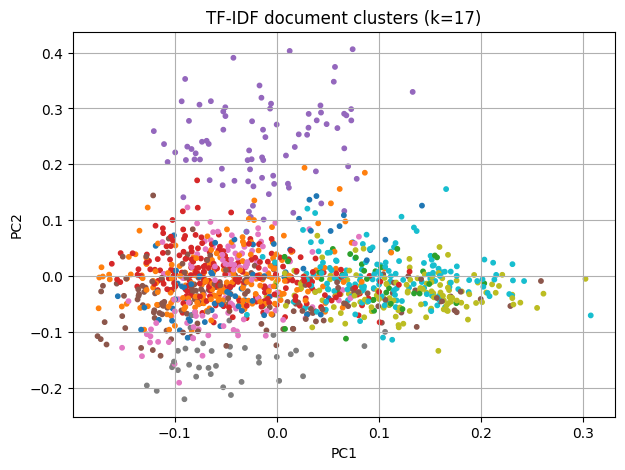

In [ ]:
if __name__ == "__main__":
    vectorizer, X, doc_ids = build_or_load_tfidf(force_rebuild=False)

    #elbow_method(X, k_min=2, k_max=50)
    silhouette_over_k(X, 2, 50)

    k = 17

    model, labels = cluster_documents_kmeans(X, k)

    print_example_docs_per_cluster(doc_ids, labels, per_cluster=5)

    plot_pca(X, labels, title=f"TF-IDF document clusters (k={k})")
